In [84]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [85]:
class NeuralNetwork:
  def __init__(self, input_nodes=784, hidden_layers=[800, 800], output_nodes=10, activation='relu', optimizer='sgd', learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):

    if activation == 'relu':
      self.activation = self.ReLU
    elif activation == 'sigmoid':
      self.activation = self.sigmoid

    self.input_nodes = input_nodes
    self.hidden_layers = hidden_layers
    self.output_nodes = output_nodes
    self.initial_lr = learning_rate

    self.weights = []
    self.biases = []

    w = 0.01 * np.random.randn(self.input_nodes, self.hidden_layers[0])
    b = np.zeros((1, self.hidden_layers[0]))
    self.weights.append(w)
    self.biases.append(b)

    for i in range(1, len(hidden_layers)):
      w = 0.01 * np.random.randn(self.hidden_layers[i-1], self.hidden_layers[i])
      b = np.zeros((1, self.hidden_layers[i]))
      self.weights.append(w)
      self.biases.append(b)

    w = 0.01 * np.random.randn(self.hidden_layers[-1], self.output_nodes)
    b = np.zeros((1, self.output_nodes))
    self.weights.append(w)
    self.biases.append(b)

    if optimizer == 'adam':
      self.optimizer = optimizer

      # Adam hyperparameters
      self.beta1 = beta1
      self.beta2 = beta2
      self.epsilon = epsilon

      self.m_w = [np.zeros_like(w) for w in self.weights]
      self.m_b = [np.zeros_like(b) for b in self.biases]
      self.v_w = [np.zeros_like(w) for w in self.weights]
      self.v_b = [np.zeros_like(b) for b in self.biases]
      self.t = 0  # time step for Adam

    else:
      self.optimizer = 'sgd'

    return


  def ReLU(self, x, d=False):
    if d:
      return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

  def sigmoid(self, x, d=False):
    if d:
      sig = 1 / (1 + np.exp(-x))
      return sig * (1 - sig)
    return 1 / (1 + np.exp(-x))


  def softmax(self, x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)


  def feed_forward(self, inputs):

    self.outputs_activation = []
    self.outputs_linear = []

    a = inputs
    self.outputs_activation.append(a)

    for i in range (len(self.hidden_layers)):
      z = np.matmul(a, self.weights[i]) + self.biases[i]
      self.outputs_linear.append(z)
      a = self.activation(z)
      self.outputs_activation.append(a)

    z = np.matmul(a, self.weights[-1]) + self.biases[-1]
    self.outputs_linear.append(z)
    a = self.softmax(z)
    self.outputs_activation.append(a)

    return self.outputs_activation[-1]

  def back_propagation(self, y, y_hat):

    m = y.shape[0]

    self.dW = []
    self.db = []

    dZ = self.outputs_activation[-1] - y
    dW = (1. / m) * np.matmul(self.outputs_activation[-2].T, dZ)
    db = (1. / m) * np.sum(dZ, axis=0, keepdims=True)

    self.dW.append(dW)
    self.db.append(db)

    for i in range(len(self.hidden_layers) - 1, -1, -1):
      dA = np.matmul(dZ, self.weights[i+1].T)
      dZ = dA * self.activation(self.outputs_linear[i], d=True)
      dW = (1. / m) * np.matmul(self.outputs_activation[i].T, dZ)
      db = (1. / m) * np.sum(dZ, axis=0, keepdims=True)
      self.dW.append(dW)
      self.db.append(db)

    self.dW.reverse()
    self.db.reverse()

    return self.dW, self.db


  def cross_entropy_loss(self, y, y_hat):

    epsilon = 1e-10
    y_hat = np.clip(y_hat, epsilon, 1. - epsilon)

    m = y.shape[0]
    l = - (1. / m) * np.sum(y * np.log(y_hat))
    return l

  def train(self, x_train, y_train, x_test, y_test, epochs, batch_size, patience=5):

    learning_rate = self.initial_lr

    best_test_loss = float('inf')
    epochs_without_improvement = 0
    best_weights = None
    best_biases = None

    # metrics
    self.epochs = epochs
    self.test_losses = []
    self.train_losses = []
    self.test_accuracies = []
    self.train_accuracies = []
    self.learning_rates = [learning_rate]

    start_time = time.time()

    for epoch in range(epochs):
      total_loss = 0
      correct_train = 0
      correct_test = 0

      # shuffle data
      indices = np.random.permutation(x_train.shape[0])
      x_train = x_train[indices]
      y_train = y_train[indices]
      num_batches = x_train.shape[0] // batch_size

      for i in range(0, x_train.shape[0], batch_size):
        x = x_train[i:i+batch_size]
        y = y_train[i:i+batch_size]

        # forward pass
        y_hat = self.feed_forward(x)
        loss = self.cross_entropy_loss(y, y_hat)
        total_loss += loss

        # back propagation and optimization
        self.back_propagation(y, y_hat)
        self.optimize(learning_rate)

        # calculate training accuracy
        y_pred = np.argmax(y_hat, axis=1)
        y_true = np.argmax(y, axis=1)
        correct_train += np.sum(y_pred == y_true)

      # training loss and accuracy
      train_loss = total_loss / num_batches
      self.train_losses.append(train_loss)
      train_accuracy = correct_train / x_train.shape[0]
      self.train_accuracies.append(train_accuracy)

      # test loss and accuracy
      y_test_hat = self.feed_forward(x_test)
      test_loss = self.cross_entropy_loss(y_test, y_test_hat)
      self.test_losses.append(test_loss)
      y_pred = np.argmax(y_test_hat, axis=1)
      y_true = np.argmax(y_test, axis=1)
      test_accuracy = np.mean(y_pred == y_true)
      self.test_accuracies.append(test_accuracy)

      # early stopping
      if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_weights = self.weights
        best_biases = self.biases
        epochs_without_improvement = 0  # reset counter
      else:
        epochs_without_improvement += 1

      if epochs_without_improvement >= patience:
        self.weights = best_weights
        self.biases = best_biases
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
        break

      learning_rate = self.exponential_decay(learning_rate, epoch, decay_rate=0.01)
      self.learning_rates.append(learning_rate)

      current_time = time.time() - start_time

      print(f"Epoch {epoch+1}/{epochs} - {current_time:.2f}s - "
            f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train Accuracy: {train_accuracy*100:.2f}%, Test Accuracy: {test_accuracy*100:.2f}%")


    # training accuracy
    y_pred = np.argmax(self.feed_forward(x_train), axis=1)
    y_true = np.argmax(y_train, axis=1)
    accuracy = np.mean(y_pred == y_true)
    print(f'\nTraining Accuracy: {accuracy}')

    # testing accuracy
    y_pred = np.argmax(self.feed_forward(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred == y_true)
    print(f'Testing Accuracy: {accuracy}')

    return self.weights, self.biases


  def optimize(self, learning_rate):
    if self.optimizer == 'sgd':
      for i in range(len(self.hidden_layers) + 1):
        self.weights[i] -= learning_rate * self.dW[i]
        self.biases[i] -= learning_rate * self.db[i]
      return self.weights, self.biases

    elif self.optimizer == 'adam':
      if learning_rate is None:
        learning_rate = self.initial_lr  # default learning rate

      self.t += 1  # increment time step

      for i in range(len(self.hidden_layers) + 1):
        # moving averages of the gradients
        self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * self.dW[i]
        self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * self.db[i]

        # moving averages of the squared gradients
        self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * np.square(self.dW[i])
        self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * np.square(self.db[i])

        # bias correction
        m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
        m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
        v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
        v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)

        self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
        self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

      return self.weights, self.biases


  def exponential_decay(self, learning_rate, epoch, decay_rate=0.01):
    return learning_rate * np.exp(-decay_rate * epoch)


  def accuracy(self, y_pred, y_true):
    return np.mean(y_pred == y_true)


  def plot_metrics_loss_acc(self):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(len(self.train_losses)), self.train_losses, color='tab:red', label='Train Loss')
    ax1.plot(range(len(self.test_losses)), self.test_losses, color='tab:orange', label='Test Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(len(self.train_accuracies)), self.train_accuracies, color='tab:blue', label='Train Accuracy')
    ax2.plot(range(len(self.test_accuracies)), self.test_accuracies, color='tab:green', label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Loss and Accuracy vs Epochs')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

  def plot_learning_rate_decay(self):
    fig, ax = plt.subplots()

    epochs = range(len(self.learning_rates))

    ax.plot(epochs, self.learning_rates, color='tab:red', label='Learning Rate')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate', color='tab:red')
    ax.set_title('Learning Rate Decay vs Epochs')

    ax.grid(True)
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()



In [86]:
from tensorflow.keras.datasets import mnist         # for the MNIST dataset
from tensorflow.keras.utils import to_categorical   # for one hot encoding

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten images from 28x28 pixel matrix to 784 array
x_train = x_train.reshape(x_train.shape[0], -1)     # (60000, 784)
x_test = x_test.reshape(x_test.shape[0], -1)        # (10000, 784)

# normalize the pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# one hot encoding labels
y_train = to_categorical(y_train, 10)               # (60000, 10)
y_test = to_categorical(y_test, 10)                 # (10000, 10)

In [87]:
nn = NeuralNetwork(input_nodes=784, hidden_layers=[800, 800], output_nodes=10, activation='relu', optimizer='adam', learning_rate=0.00125)
weights, biases = nn.train(x_train, y_train, x_test, y_test, epochs=20, batch_size=64)

Epoch 1/20 - 49.14s - Train Loss: 0.2281, Test Loss: 0.1057, Train Accuracy: 93.03%, Test Accuracy: 96.77%
Epoch 2/20 - 99.50s - Train Loss: 0.0873, Test Loss: 0.0741, Train Accuracy: 97.25%, Test Accuracy: 97.83%
Epoch 3/20 - 147.52s - Train Loss: 0.0586, Test Loss: 0.0886, Train Accuracy: 98.12%, Test Accuracy: 97.61%
Epoch 4/20 - 197.61s - Train Loss: 0.0427, Test Loss: 0.0795, Train Accuracy: 98.68%, Test Accuracy: 97.82%
Epoch 5/20 - 245.72s - Train Loss: 0.0324, Test Loss: 0.0847, Train Accuracy: 98.95%, Test Accuracy: 97.75%
Epoch 6/20 - 294.03s - Train Loss: 0.0279, Test Loss: 0.0915, Train Accuracy: 99.15%, Test Accuracy: 97.79%
Epoch 7/20 - 343.72s - Train Loss: 0.0188, Test Loss: 0.0725, Train Accuracy: 99.40%, Test Accuracy: 98.28%
Epoch 8/20 - 410.47s - Train Loss: 0.0167, Test Loss: 0.0964, Train Accuracy: 99.47%, Test Accuracy: 97.67%
Epoch 9/20 - 476.74s - Train Loss: 0.0141, Test Loss: 0.0746, Train Accuracy: 99.57%, Test Accuracy: 98.41%
Epoch 10/20 - 545.25s - Train 

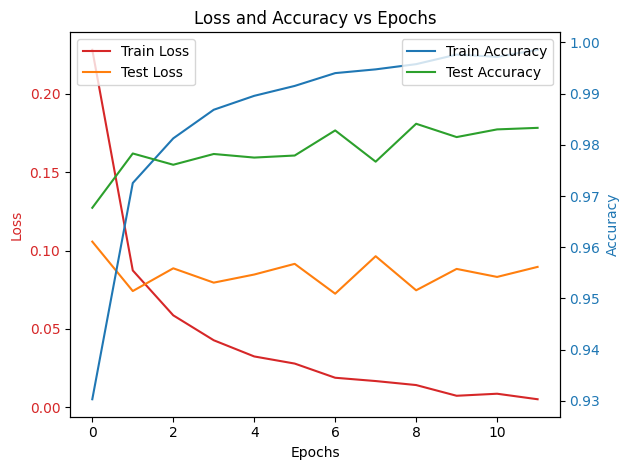

In [88]:
nn.plot_metrics_loss_acc()

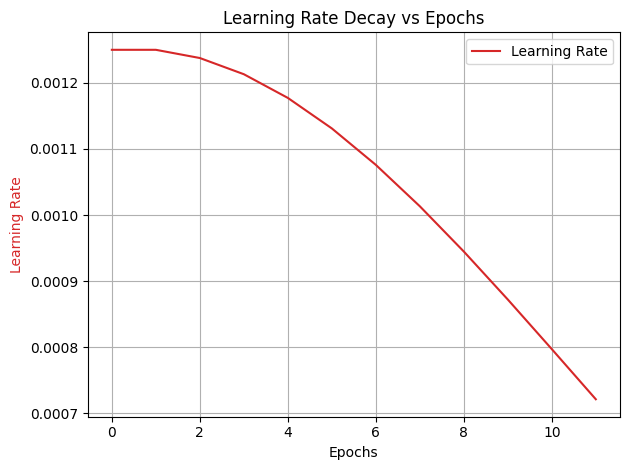

In [89]:
nn.plot_learning_rate_decay()